Expected Threat (xT) Model for AFL

In [1]:
import pandas as pd
import numpy as np
from mplfooty.pitch import Pitch
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from highlight_text import fig_text

import sys
sys.path.append("..")
from config import chain_file_path, shots_file_path

import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
import xthreat as xthreat

In [3]:
import matplotlib.font_manager as fm

font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/fonts"
for x in os.listdir(font_path):
    if x != ".DS_Store":
        for y in os.listdir(f"{font_path}/{x}"):
            if y.split(".")[-1] == "ttf":
                fm.fontManager.addfont(f"{font_path}/{x}/{y}")
                try:
                    fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
                except Exception:
                    continue
plt.style.use("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/mplstyle/dark_theme.mplstyle")

Load Data

In [4]:
chains = pd.read_csv(chain_file_path)
chains.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season
1169201,252,ballUp,turnover,1984.0,4,1937,1942.0,St Kilda,St Kilda,Dan Butler,Dan_Butler,Kick,-65.0,14.0,clanger,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169202,252,ballUp,turnover,1985.0,4,1937,1945.0,St Kilda,St Kilda,Dan Butler,Dan_Butler,Out On Full After Kick,-69.0,34.0,NaN,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169203,253,possGain,behind,1986.0,4,1949,1949.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,OOF Kick In,67.0,-34.0,NaN,NaN,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169204,253,possGain,behind,1987.0,4,1949,1976.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,Kick,67.0,-34.0,ineffective,True,NaN,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0
1169205,253,possGain,behind,1988.0,4,1949,1978.0,North Melbourne,North Melbourne,Luke Davies-Uniacke,Luke_Davies-Uniacke,Behind,67.0,-34.0,NaN,NaN,missLeft,129,160,St Kilda,North Melbourne,left,202319_StKilda_NorthMelbourne,202319,NaN,2023.0


Expected Threat (xT)

In [5]:
def convert_chain_to_spadl(chains):
    
    xthreat_data = chains.copy()

    xthreat_data = xthreat_data.dropna(subset=['Player'])
    xthreat_data = xthreat_data[~(xthreat_data['Description']=="Kick Into F50")]
    xthreat_data = xthreat_data[~(xthreat_data['Description']=="Goal")]

    xthreat_data['end_x'] = xthreat_data.groupby('Match_ID')['x'].shift(-1).fillna(0)
    xthreat_data['end_y'] = xthreat_data.groupby('Match_ID')['y'].shift(-1).fillna(0)

    xthreat_data['type_name'] = np.where(xthreat_data['Description'] == "Handball", "Handball",
                                        np.where((xthreat_data['Description'] == 'Kick') & (xthreat_data['Shot_At_Goal']==True), "Shot",
                                                np.where(xthreat_data['Description']=='Kick', "Kick",
                                                            "Carry")))
    xthreat_data['outcome_name'] = (xthreat_data['type_name'] == "Carry") | (xthreat_data['Disposal'] == "effective")
    xthreat_data['goal'] = (xthreat_data['type_name'] == "Shot") & (xthreat_data['Final_State'] == "goal")
    xthreat_data['shoot'] = xthreat_data['type_name'] == "Shot"
    xthreat_data['move'] = xthreat_data['type_name'] != "Shot"

    xthreat_data['Year'] = xthreat_data['Match_ID'].apply(lambda x: int(x[:4]))
    xthreat_data = xthreat_data[['Match_ID', 'Year', 'Team', 'Player', 'type_name', 'outcome_name', 'shoot', 'move', 'goal', 'x', 'y', 'end_x', 'end_y']]
    
    return xthreat_data

In [6]:
actions = convert_chain_to_spadl(chains)
actions.head()

,Match_ID,Year,Team,Player,type_name,outcome_name,shoot,move,goal,x,y,end_x,end_y
1,202101_BrisbaneLions_Sydney,2021,Brisbane Lions,Dayne Zorko,Carry,True,False,True,False,8.0,-5.0,9.0,-6.0
2,202101_BrisbaneLions_Sydney,2021,Brisbane Lions,Dayne Zorko,Handball,False,False,True,False,9.0,-6.0,11.0,-7.0
3,202101_BrisbaneLions_Sydney,2021,Sydney,Oliver Florent,Carry,True,False,True,False,11.0,-7.0,12.0,-5.0
4,202101_BrisbaneLions_Sydney,2021,Sydney,Oliver Florent,Handball,True,False,True,False,12.0,-5.0,14.0,-2.0
5,202101_BrisbaneLions_Sydney,2021,Sydney,George Hewett,Carry,True,False,True,False,14.0,-2.0,22.0,-2.0


Create Expected Threat (xT) Model

In [7]:
xTModel = xthreat.ExpectedThreat()

In [9]:
xTModel.fit(actions)

Number of iterations:  61


Save model

In [24]:
xTModel.save_model("models/xT_v02.json")

Score Actions

In [12]:
move_actions = xthreat.get_successful_move_actions(actions)
move_actions['xT'] = xTModel.rate(move_actions)
move_actions.head()

,Match_ID,Year,Team,Player,type_name,outcome_name,shoot,move,goal,x,y,end_x,end_y,xT
1,202101_BrisbaneLions_Sydney,2021,Brisbane Lions,Dayne Zorko,Carry,True,False,True,False,8.0,-5.0,9.0,-6.0,0.005595
3,202101_BrisbaneLions_Sydney,2021,Sydney,Oliver Florent,Carry,True,False,True,False,11.0,-7.0,12.0,-5.0,0.000000
4,202101_BrisbaneLions_Sydney,2021,Sydney,Oliver Florent,Handball,True,False,True,False,12.0,-5.0,14.0,-2.0,0.007561
5,202101_BrisbaneLions_Sydney,2021,Sydney,George Hewett,Carry,True,False,True,False,14.0,-2.0,22.0,-2.0,0.020650
7,202101_BrisbaneLions_Sydney,2021,Brisbane Lions,Hugh McCluggage,Carry,True,False,True,False,6.0,-27.0,11.0,-26.0,0.001855


Check Player xT

In [13]:
def get_total_by_player(threat, top_n=10):
    
    return threat.groupby('Player')['xT'].sum().sort_values(ascending=False).head(top_n)

In [14]:
get_total_by_player(move_actions)

Player
Christian Petracca    24.795308
Jack Macrae           20.665950
Darcy Parish          19.130888
Zach Merrett          18.136401
Clayton Oliver        17.462719
Isaac Smith           16.879112
Adam Cerra            16.554790
Marcus Bontempelli    16.316683
Chad Warner           16.241876
Noah Anderson         16.166402
Name: xT, dtype: float64

In [15]:
def get_player_threat(threat, player):
    
    player = threat[threat['Player'] == player]
    return player.groupby('type_name')['xT'].sum()

In [16]:
get_player_threat(move_actions, "Christian Petracca")

type_name
Carry       -7.459576
Handball     1.661464
Kick        30.593420
Name: xT, dtype: float64

Plot Results

In [17]:
l = xthreat.x_bins
w = xthreat.y_bins
bins = (l, w)

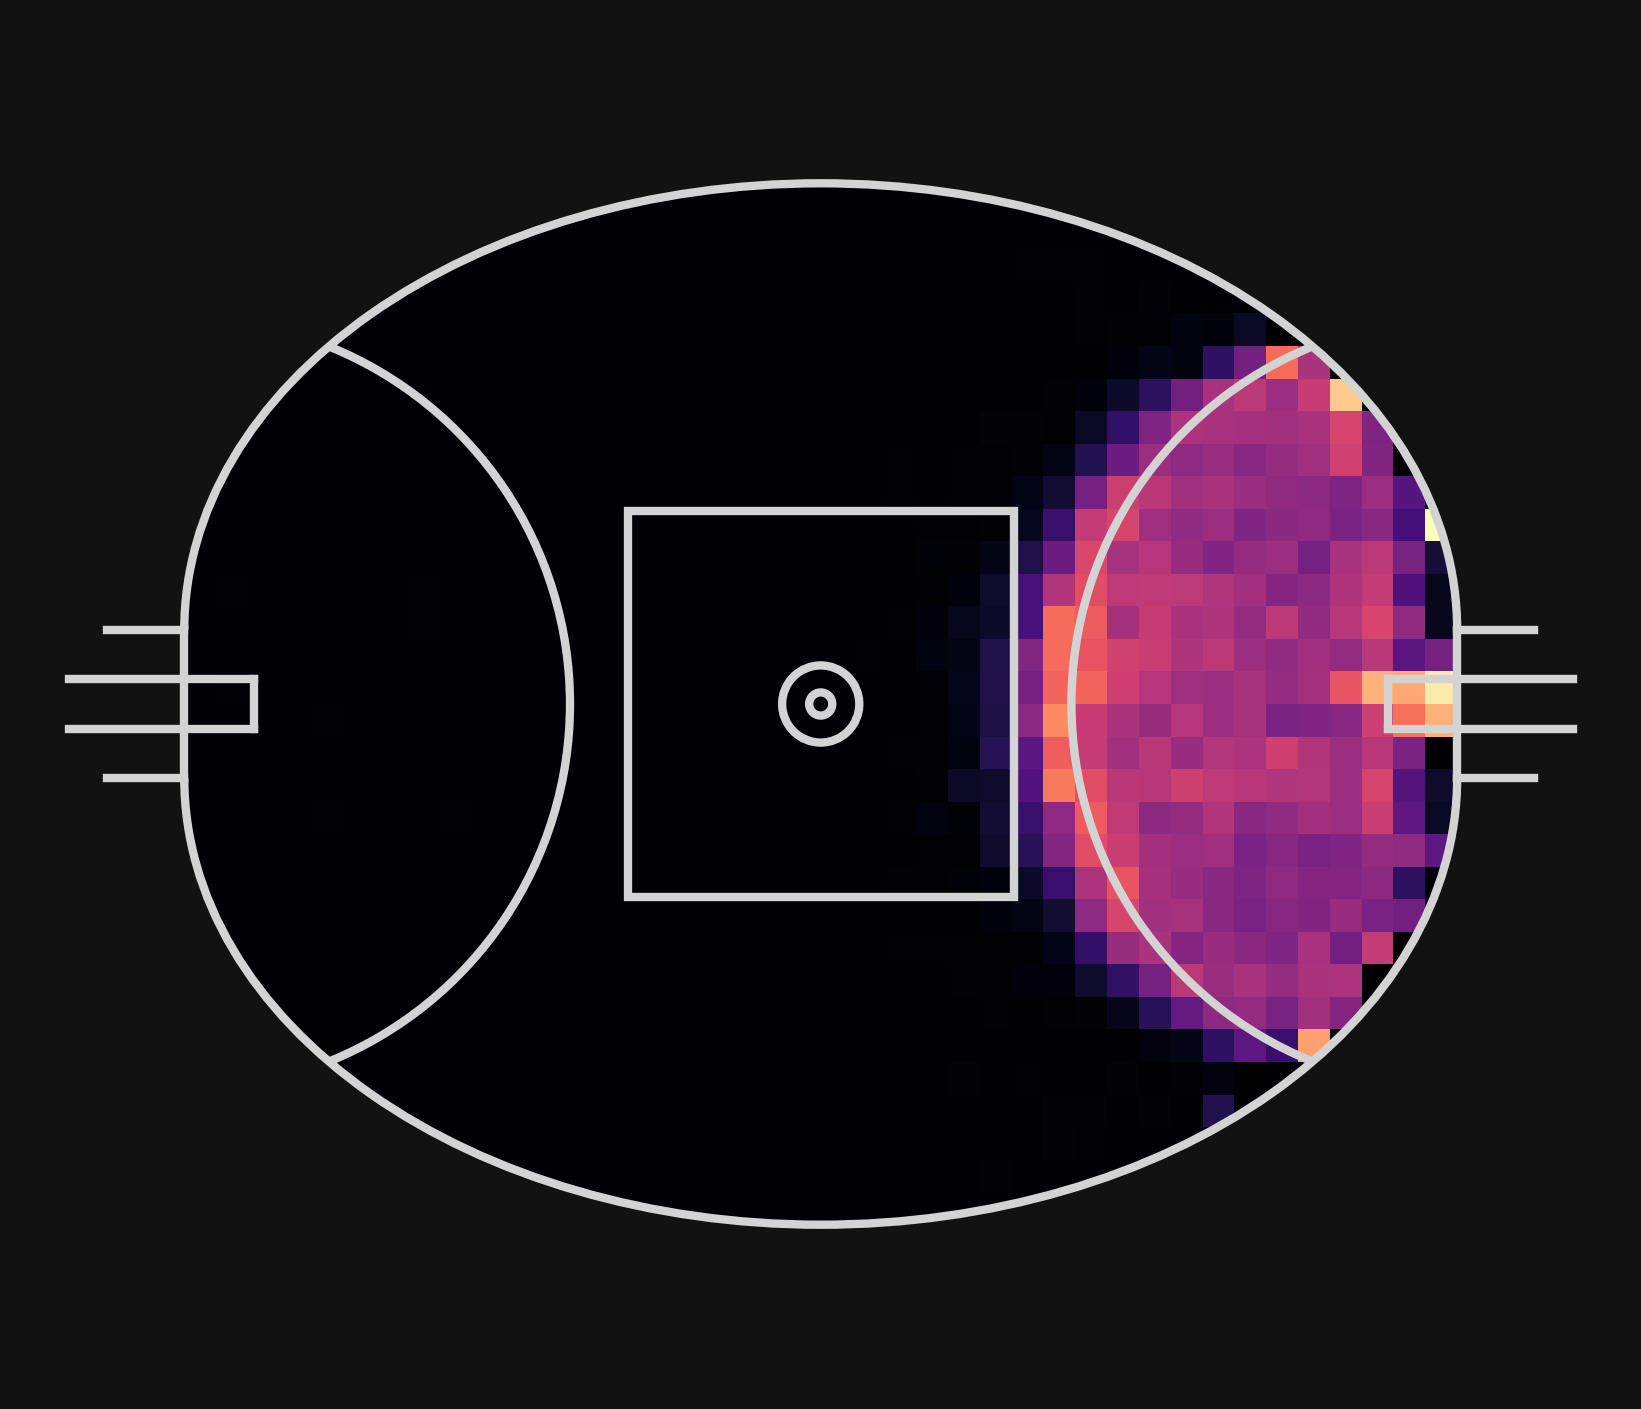

In [19]:
pitch = Pitch(pitch_length=xthreat.pitch_length, pitch_width=xthreat.pitch_width, line_zorder=2)
shot_probability = pitch.bin_statistic(actions['x'], actions['y'], bins=bins)
shot_probability['statistic'] = xTModel.shot_prob_matrix
fig, ax = pitch.draw()
fig.dpi = 300
shot_heatmap = pitch.heatmap(shot_probability, ax=ax, cmap = "magma")

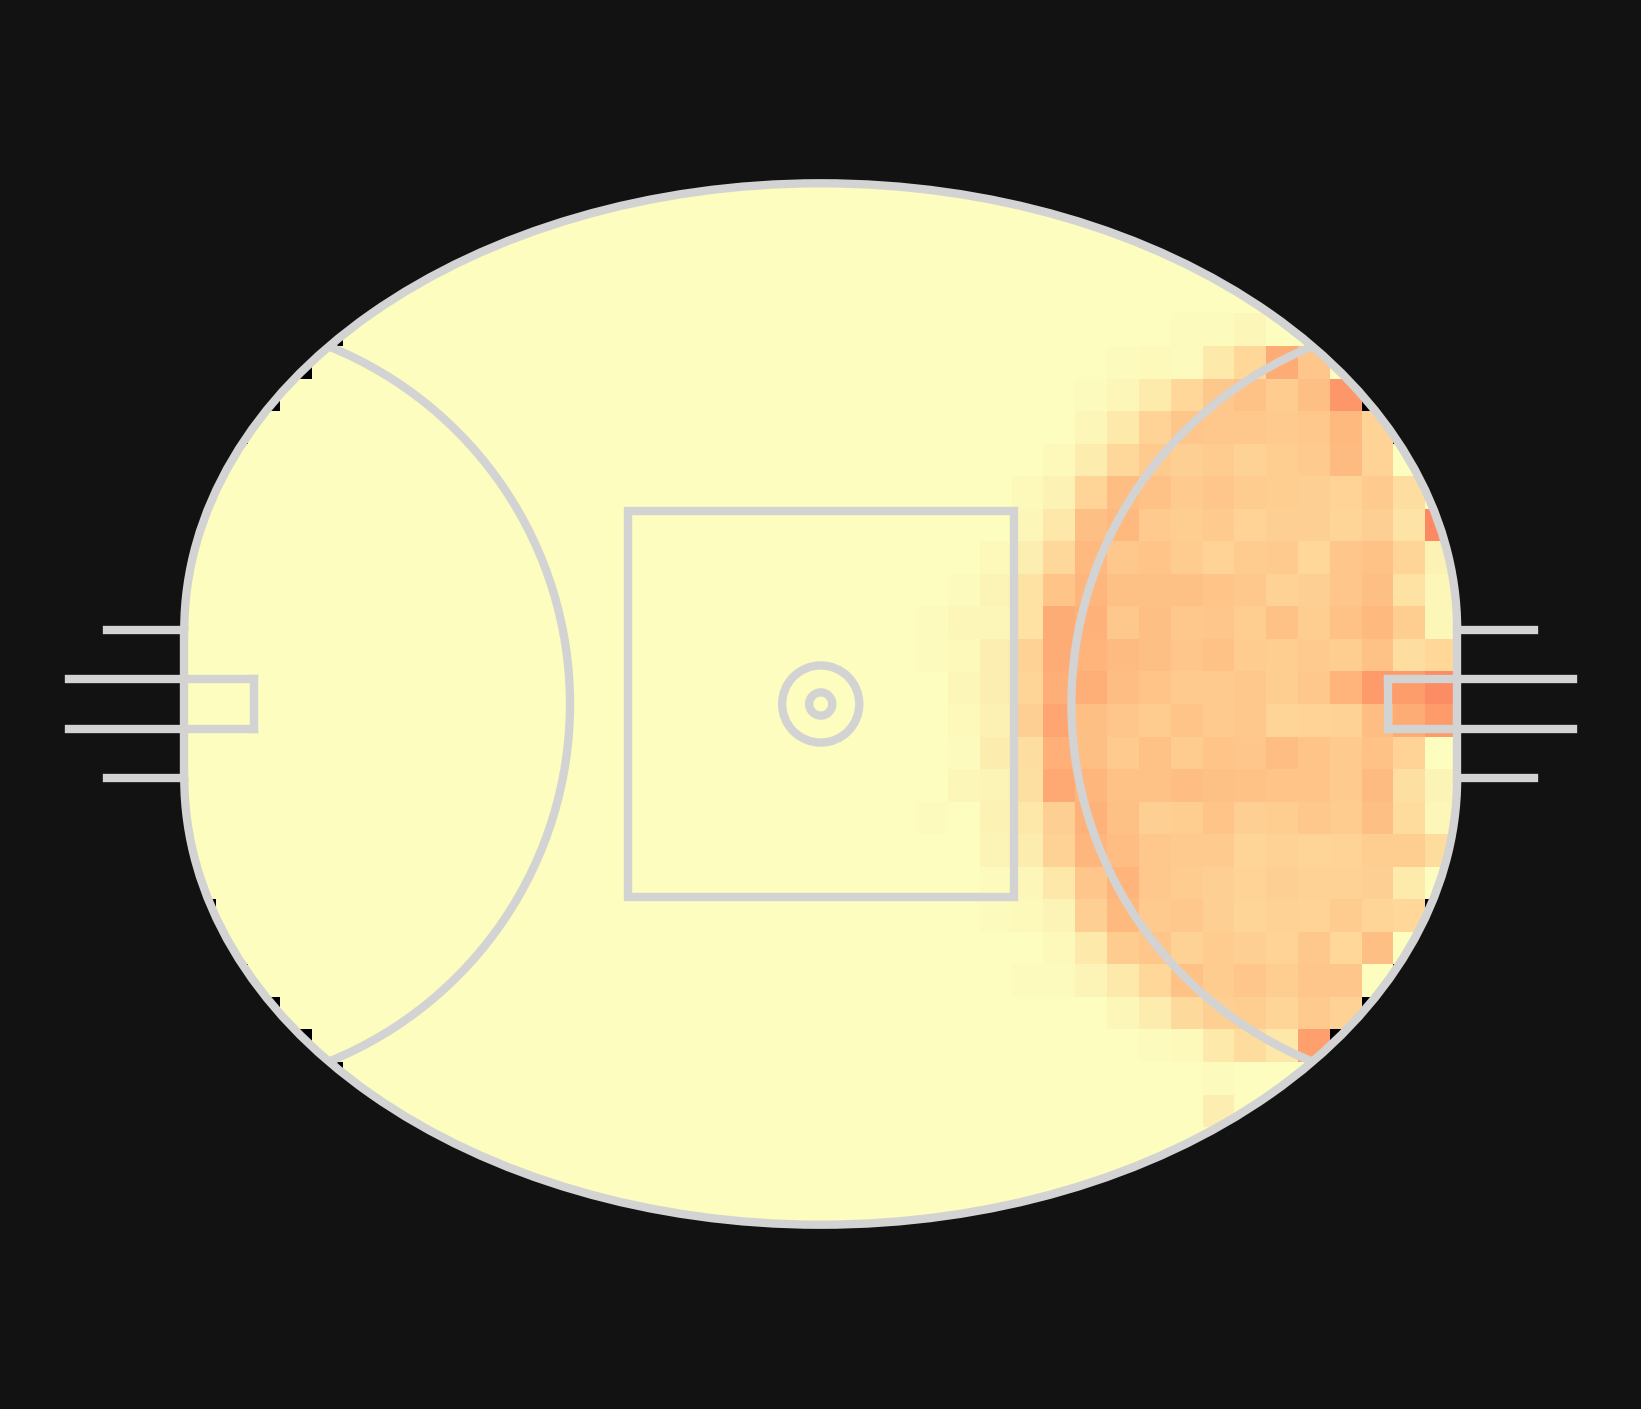

In [20]:
pitch = Pitch(pitch_length=xthreat.pitch_length, pitch_width=xthreat.pitch_width, line_zorder=2)
move_probability = pitch.bin_statistic(actions['x'], actions['y'], bins=bins)
move_probability['statistic'] = xTModel.move_prob_matrix
fig, ax = pitch.draw()
fig.dpi = 300
move_heatmap = pitch.heatmap(move_probability, ax=ax, cmap = "magma")

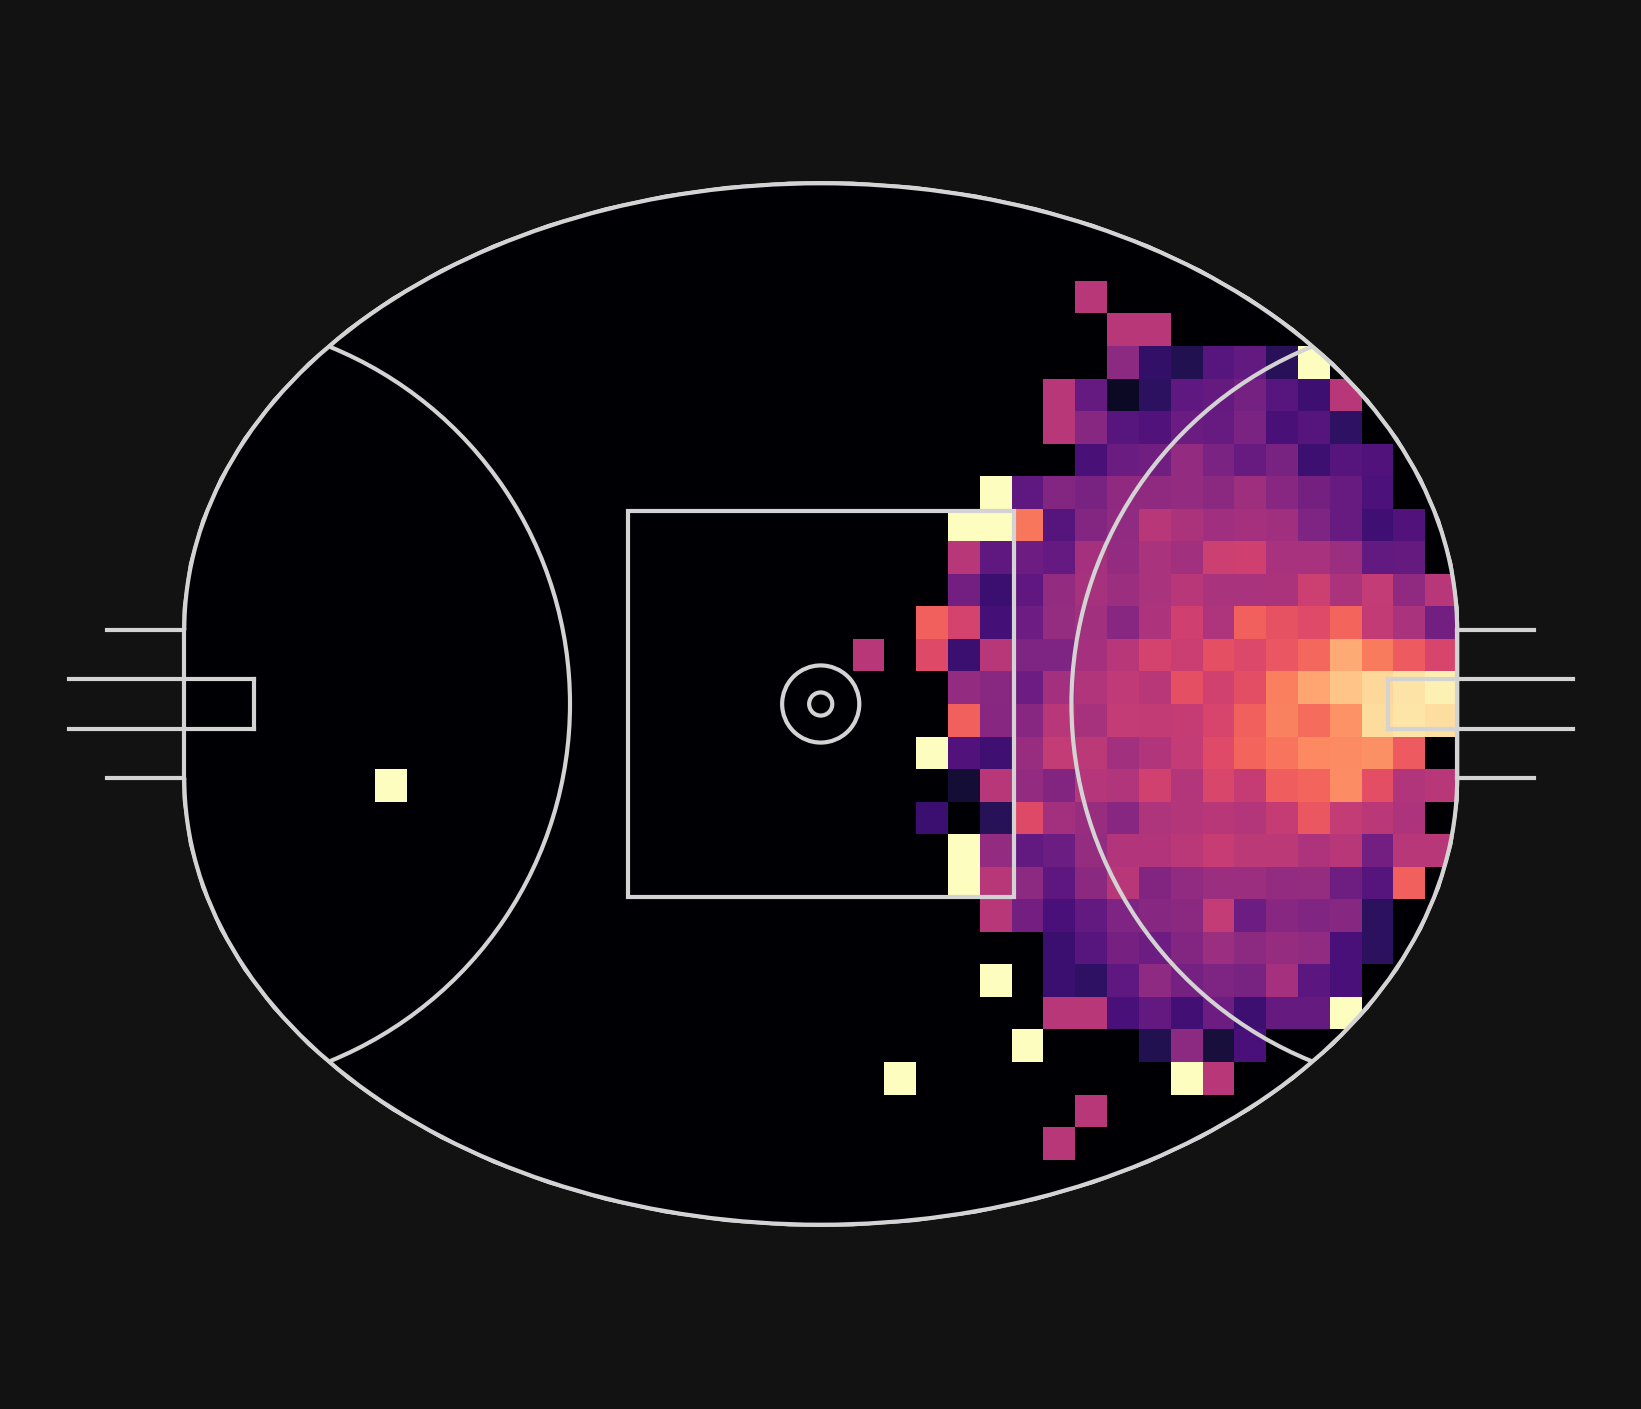

In [21]:
pitch = Pitch(pitch_length=xthreat.pitch_length, pitch_width=xthreat.pitch_width, line_zorder=2, line_width = 1)
goal_probability = pitch.bin_statistic(actions['x'], actions['y'], bins=bins)
goal_probability['statistic'] = xTModel.scoring_prob_matrix
fig, ax = pitch.draw()
fig.dpi = 300
goal_heatmap = pitch.heatmap(goal_probability, ax=ax, cmap = "magma")

In [22]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground="black"),
            path_effects.Normal()]

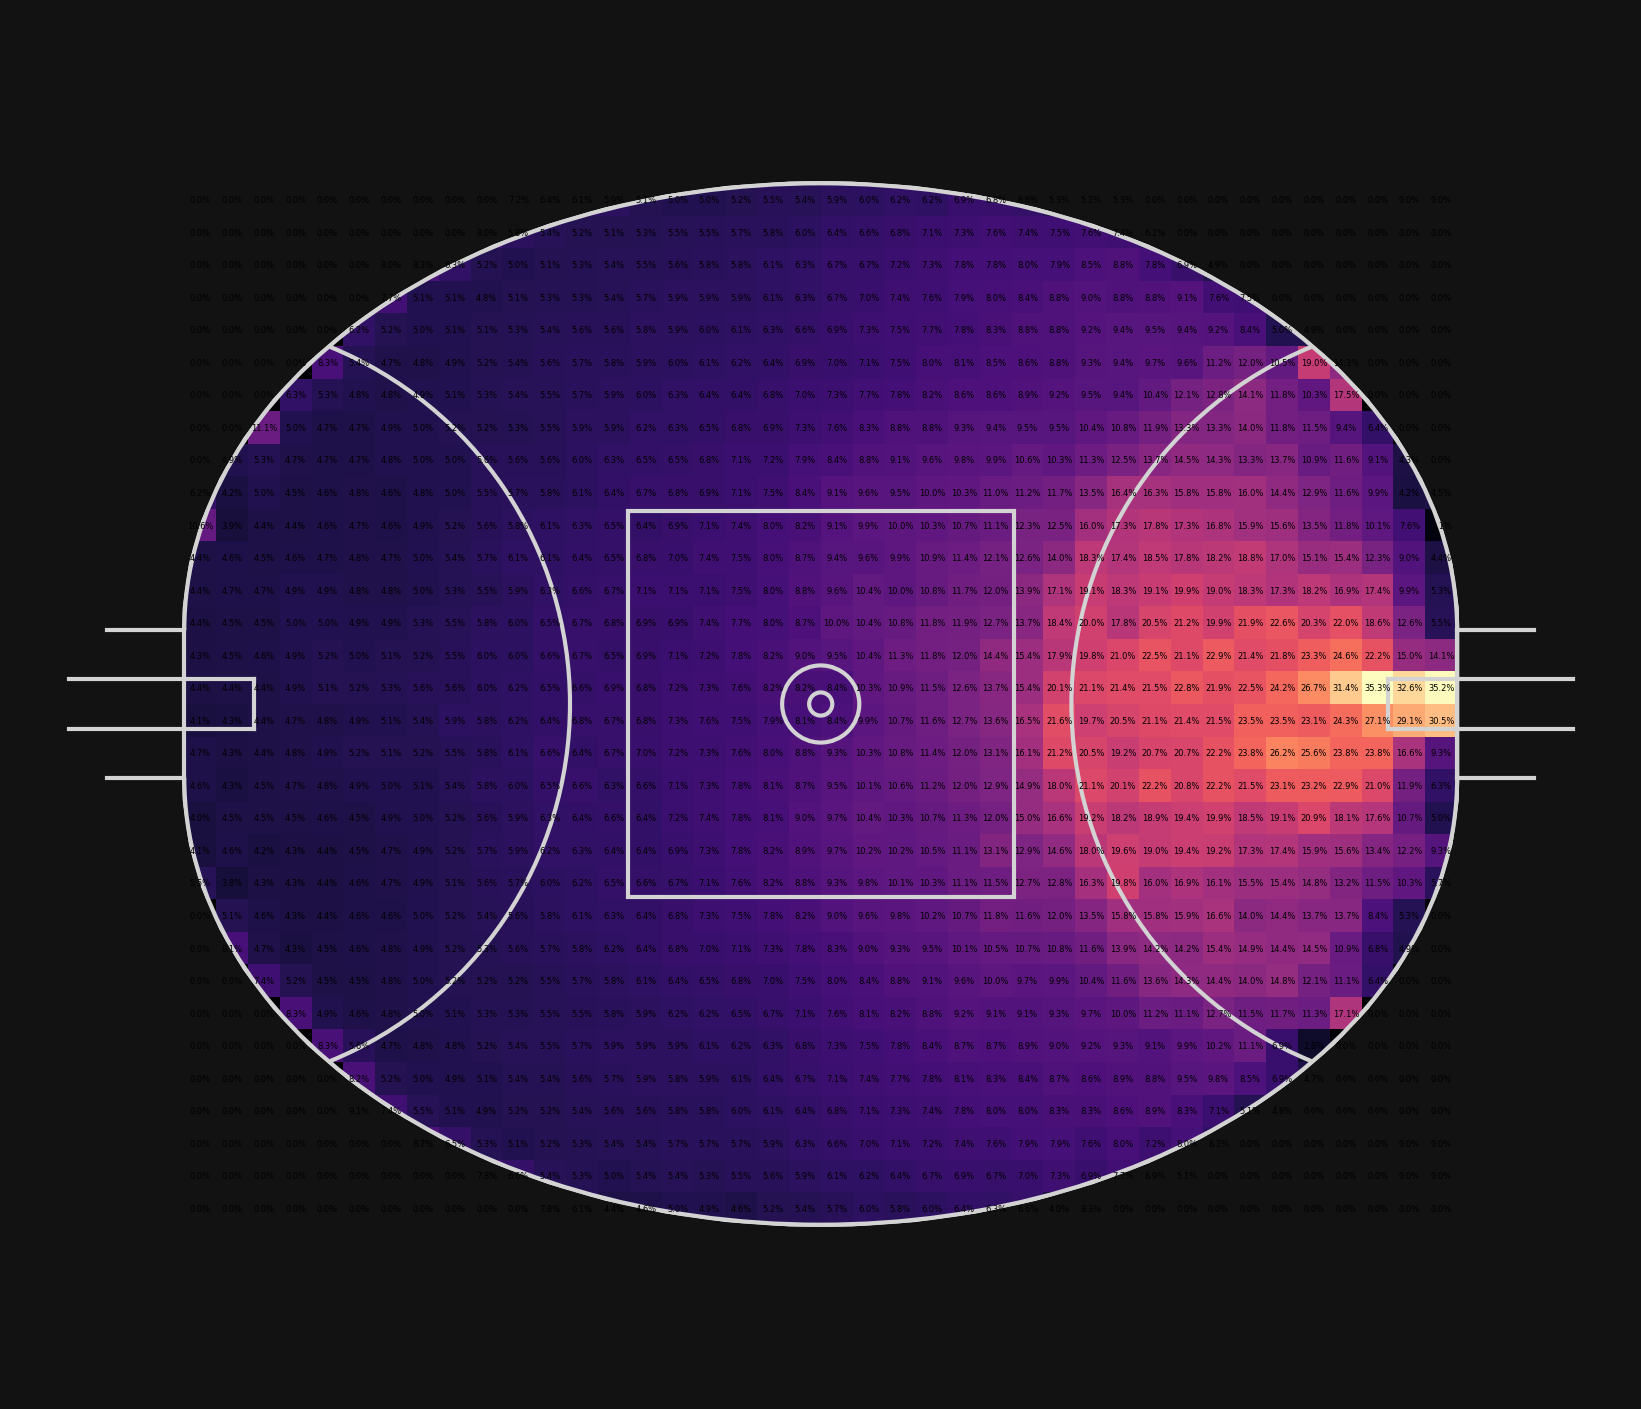

In [23]:
pitch = Pitch(pitch_length=xthreat.pitch_length, pitch_width=xthreat.pitch_width, line_zorder=2, line_width = 1)
threat_probability = pitch.bin_statistic(actions['x'], actions['y'], bins=bins)
threat_probability['statistic'] = xTModel.xT
fig, ax = pitch.draw()
fig.dpi = 300
threat_heatmap = pitch.heatmap(threat_probability, ax=ax, cmap = "magma")
label_heatmap = pitch.label_heatmap(threat_probability, ax=ax, str_format='{:.1%}', color="black", fontsize=2, va="center", ha="center")
